In [1]:
pip install yfinance pandas numpy matplotlib statsmodels tensorflow


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


[*********************100%***********************]  1 of 1 completed


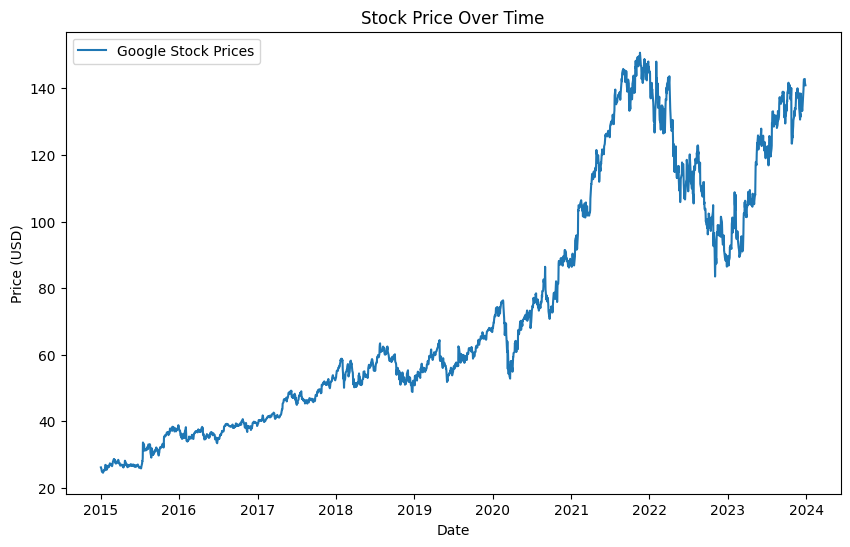

In [3]:
# Fetch stock data
data = yf.download("GOOG", start="2015-01-01", end="2023-12-31")
data = data['Close']  # Use 'Close' prices for prediction

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data, label="Google Stock Prices")
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


ADF Statistic: -0.13728156636291858
P-value: 0.9455961954881226


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

ARIMA Forecast:
2264    141.027996
2265    141.481344
2266    142.111493
2267    142.570280
2268    142.623555
2269    142.243564
2270    141.629274
2271    141.098470
2272    140.924629
2273    141.195786
2274    141.770121
2275    142.350062
2276    142.636466
2277    142.482913
2278    141.970547
2279    141.365223
2280    140.979563
2281    141.011509
2282    141.442737
2283    142.049062
2284    142.516982
2285    142.605769
2286    142.271304
2287    141.687971
2288    141.157739
2289    140.953854
2290    141.180031
2291    141.717711
2292    142.288192
2293    142.597090
Name: predicted_mean, dtype: float64


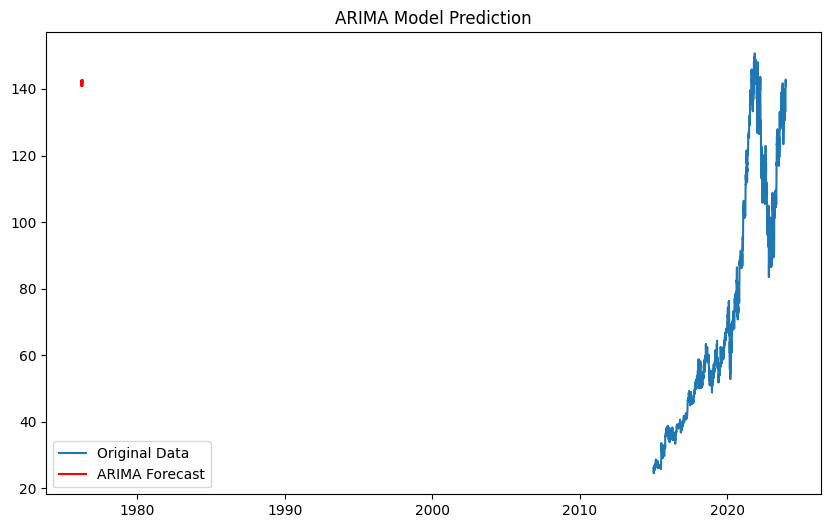

In [4]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity
result = adfuller(data)
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")

# Differencing if needed
data_diff = data.diff().dropna()

# Train ARIMA
p, d, q = 5, 1, 2  # Example parameters; tune these
model_arima = ARIMA(data, order=(p, d, q))
model_fit_arima = model_arima.fit()

# Forecast
forecast_arima = model_fit_arima.forecast(steps=30)
print(f"ARIMA Forecast:\n{forecast_arima}")

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(data, label="Original Data")
plt.plot(forecast_arima, label="ARIMA Forecast", color="red")
plt.title("ARIMA Model Prediction")
plt.legend()
plt.show()


In [5]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Create training dataset
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, step):
    X, y = [], []
    for i in range(len(data) - step):
        X.append(data[i:i + step])
        y.append(data[i + step])
    return np.array(X), np.array(y)

step = 60  # Look-back window size
X_train, y_train = create_sequences(train_data, step)
X_test, y_test = create_sequences(test_data, step)


In [6]:
# Build LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(step, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# Train the model
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0766 - val_loss: 0.0032
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 6.2365e-04 - val_loss: 0.0020
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 5.6560e-04 - val_loss: 0.0017
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.5433e-04 - val_loss: 0.0019
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 4.9175e-04 - val_loss: 0.0016
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 4.1689e-04 - val_loss: 0.0019
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 4.6491e-04 - val_loss: 0.0017
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 3.9407e-04 - val_loss: 0.0017
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 3.7363e-04 - val_loss: 0.0016
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 3.9243e-04 - val_loss: 0.0015
Epoch 12/20
55/55 ━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


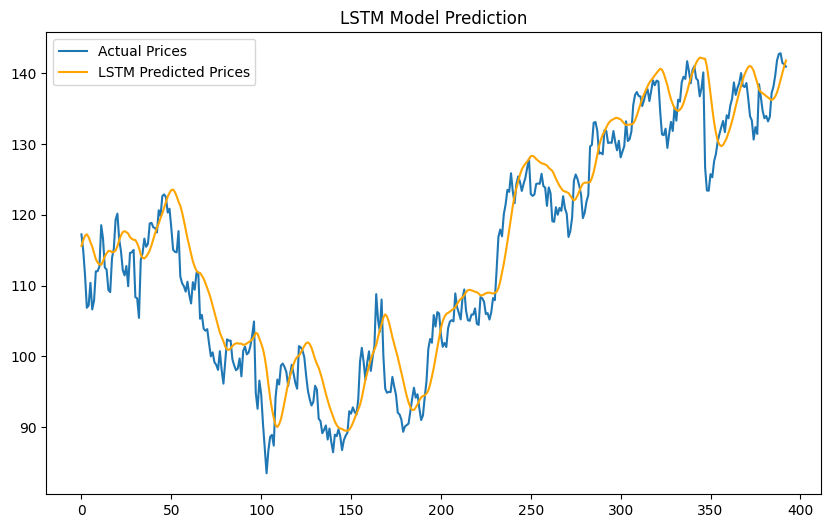

In [7]:
# Predict on test data
predicted = model_lstm.predict(X_test)
predicted = scaler.inverse_transform(predicted)  # Rescale predictions

# Rescale actual values
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(actual, label="Actual Prices")
plt.plot(predicted, label="LSTM Predicted Prices", color="orange")
plt.title("LSTM Model Prediction")
plt.legend()
plt.show()


In [8]:
model_lstm.save("lstm_stock_model.keras")
